In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime, nltk, warnings
import matplotlib.cm as cm
import itertools
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn import preprocessing, model_selection, metrics, feature_selection
from sklearn.model_selection import GridSearchCV, learning_curve
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix
from sklearn import neighbors, linear_model, svm, tree, ensemble
from wordcloud import WordCloud, STOPWORDS
from sklearn.ensemble import AdaBoostClassifier
from sklearn.decomposition import PCA
from IPython.display import display, HTML
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
warnings.filterwarnings("ignore")
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [251]:
data=pd.read_csv('retail.csv', sep = ',',encoding = "ISO-8859-1", header= 0)
data['Quantity'] = data['Quantity'].apply(abs)
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [4]:
is_noun = lambda pos: pos[:2] == 'NN'
data = data.dropna()

def keywords_inventory(dataframe, colonne = 'Description'):
    stemmer = nltk.stem.SnowballStemmer("english")
    keywords_roots  = dict()  # collect the words / root
    keywords_select = dict()  # association: root <-> keyword
    category_keys   = []
    count_keywords  = dict()
    icount = 0
    for s in dataframe[colonne]:
        if pd.isnull(s): continue
        lines = s.lower()
        tokenized = nltk.word_tokenize(lines)
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)] 
        
        for t in nouns:
            t = t.lower() ; racine = stemmer.stem(t)
            if racine in keywords_roots:                
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1                
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:  
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k ; min_length = len(k)            
            category_keys.append(clef)
            keywords_select[s] = clef
        else:
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
                   
    print("Nb of keywords in variable '{}': {}".format(colonne,len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords

In [5]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:'Description'})

In [6]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Nb of keywords in variable 'Description': 1484


In [7]:
list_products = []
for k,v in count_keywords.items():
    list_products.append([keywords_select[k],v])
list_products.sort(key = lambda x:x[1], reverse = True)

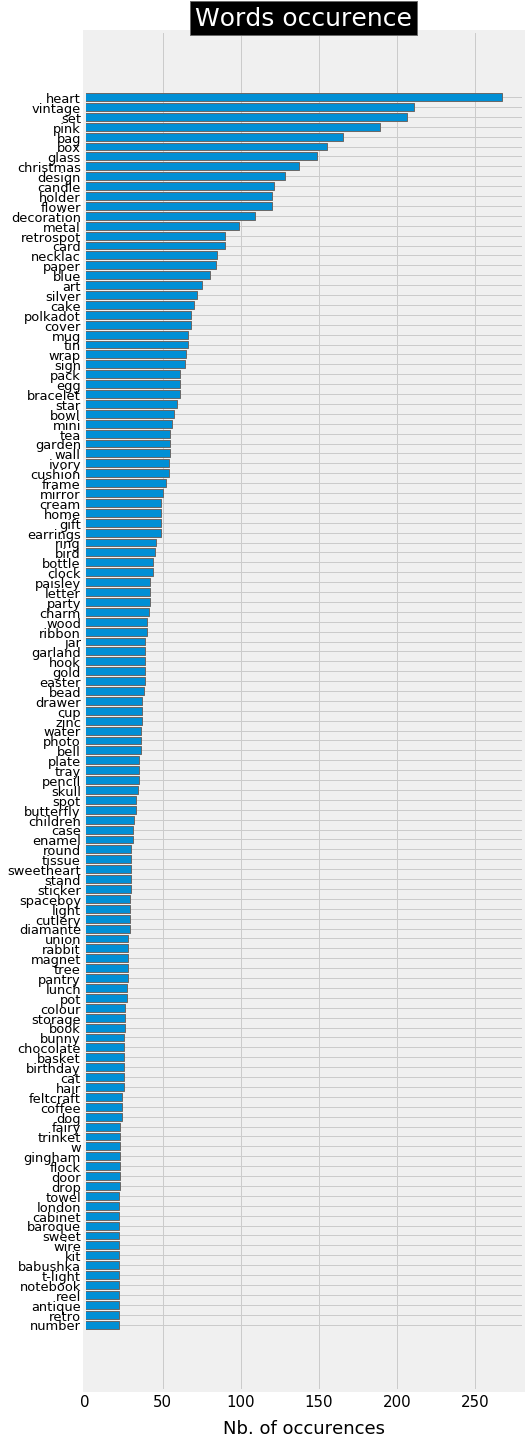

In [8]:
liste = sorted(list_products, key = lambda x:x[1], reverse = True)
#_______________________________
plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 13)
plt.yticks(x_axis, x_label)
plt.xlabel("Nb. of occurences", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align = 'center')
ax = plt.gca()
ax.invert_yaxis()
#_______________________________________________________________________________________
plt.title("Words occurence",bbox={'facecolor':'k', 'pad':5}, color='w',fontsize = 25)
plt.show()

In [9]:
list_products = []
for k,v in count_keywords.items():
    word = keywords_select[k]
    if word in ['pink', 'blue', 'tag', 'green', 'orange']: continue
    if len(word) < 3 or v < 13: continue
    if ('+' in word) or ('/' in word): continue
    list_products.append([word, v])
#______________________________________________________    
list_products.sort(key = lambda x:x[1], reverse = True)
print('mots common:', len(list_products))

mots common: 193


In [10]:
liste_produits = data['Description'].unique()
#print(liste_produits)
X = pd.DataFrame()
#print(list_products)
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x:int(key.upper() in str(x)),liste_produits))

In [11]:
threshold = [0, 1, 2, 3, 5, 10]
label_col = []
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])
    label_col.append(col)
    X.loc[:, col] = 0

for i, prod in enumerate(liste_produits):
    prix = data[data['Description'] == prod]['UnitPrice'].mean()
    j = 0
    while prix > threshold[j]:
        j+=1
        if j == len(threshold): break
    X.loc[i, label_col[j-1]] = 1

In [12]:
print("{:<8} {:<20} \n".format('gamme', 'nb. produits') + 20*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = '.>{}'.format(threshold[i])
    else:
        col = '{}<.<{}'.format(threshold[i],threshold[i+1])    
    print("{:<10}  {:<20}".format(col, X.loc[:, col].sum()))

gamme    nb. produits         
--------------------
0<.<1       964                 
1<.<2       1013                
2<.<3       675                 
3<.<5       613                 
5<.<10      473                 
.>10        158                 


In [13]:
matrix = X.as_matrix()
for n_clusters in range(3,10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 3 The average silhouette_score is : 0.10145785321029076
For n_clusters = 4 The average silhouette_score is : 0.12671332458899262
For n_clusters = 5 The average silhouette_score is : 0.146841915415706
For n_clusters = 6 The average silhouette_score is : 0.15183207356321635
For n_clusters = 7 The average silhouette_score is : 0.14917683143832486
For n_clusters = 8 The average silhouette_score is : 0.14025377387061783
For n_clusters = 9 The average silhouette_score is : 0.14981213685043074


In [14]:
n_clusters = 5
silhouette_avg = -1
while silhouette_avg < 0.145:
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    silhouette_avg = silhouette_score(matrix, clusters)
    
    #km = kmodes.KModes(n_clusters = n_clusters, init='Huang', n_init=2, verbose=0)
    #clusters = km.fit_predict(matrix)
    #silhouette_avg = silhouette_score(matrix, clusters)
    print("For n_clusters =", n_clusters, "The average silhouette_score is :", silhouette_avg)

For n_clusters = 5 The average silhouette_score is : 0.14754871236216777


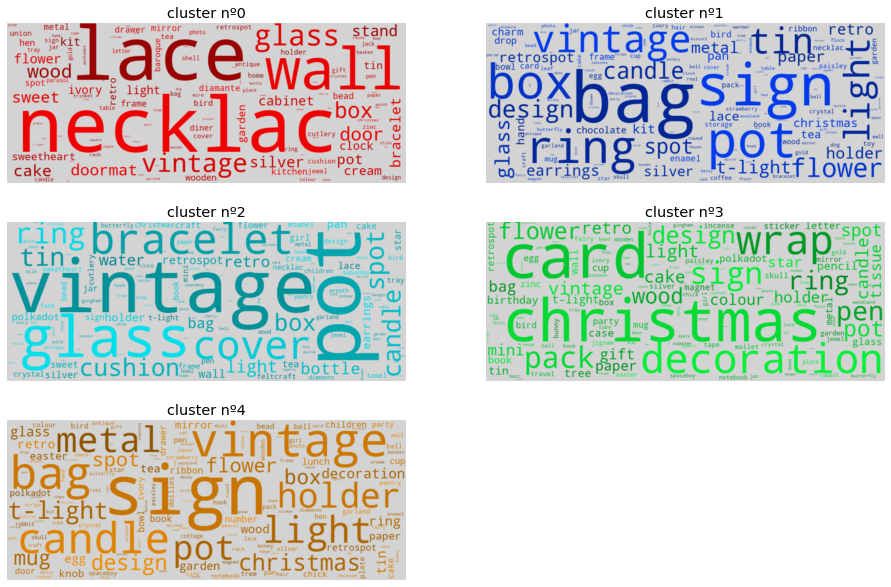

In [15]:
liste = pd.DataFrame(liste_produits)
liste_words = [word for (word, occurence) in list_products]

occurence = [dict() for _ in range(n_clusters)]

for i in range(n_clusters):
    liste_cluster = liste.loc[clusters == i]
    for word in liste_words:
        if word in ['art', 'set', 'heart', 'pink', 'blue', 'tag']: continue
        occurence[i][word] = sum(liste_cluster.loc[:, 0].str.contains(word.upper()))


def random_color_func(word=None, font_size=None, position=None,
                      orientation=None, font_path=None, random_state=None):
    h = int(360.0 * tone / 255.0)
    s = int(100.0 * 255.0 / 255.0)
    l = int(100.0 * float(random_state.randint(70, 120)) / 255.0)
    return "hsl({}, {}%, {}%)".format(h, s, l)
#________________________________________________________________________
def make_wordcloud(liste, increment):
    ax1 = fig.add_subplot(4,2,increment)
    words = dict()
    trunc_occurences = liste[0:150]
    for s in trunc_occurences:
        words[s[0]] = s[1]
    #________________________________________________________
    wordcloud = WordCloud(width=1000,height=400, background_color='lightgrey', 
                          max_words=1628,relative_scaling=1,
                          color_func = random_color_func,
                          normalize_plurals=False)
    wordcloud.generate_from_frequencies(words)
    ax1.imshow(wordcloud, interpolation="bilinear")
    ax1.axis('off')
    plt.title('cluster nº{}'.format(increment-1))
#________________________________________________________________________
fig = plt.figure(1, figsize=(14,14))
color = [0, 160, 130, 95, 280, 40, 330, 110, 25]
for i in range(n_clusters):
    list_cluster_occurences = occurence[i]

    tone = color[i] # define the color of the words
    liste = []
    for key, value in list_cluster_occurences.items():
        liste.append([key, value])
    liste.sort(key = lambda x:x[1], reverse = True)
    make_wordcloud(liste, i+1) 

In [16]:
df_cleaned = data.copy(deep = True)
df_cleaned['QuantityCanceled'] = 0

entry_to_remove = [] ; doubtfull_entry = []

for index, col in  data.iterrows():
    if (col['Quantity'] > 0) or col['Description'] == 'Discount': continue        
    df_test = data[(data['CustomerID'] == col['CustomerID']) &
                         (data['StockCode']  == col['StockCode']) & 
                         (data['InvoiceDate'] < col['InvoiceDate']) & 
                         (data['Quantity']   > 0)].copy()
    #_________________________________
    # Cancelation WITHOUT counterpart
    if (df_test.shape[0] == 0): 
        doubtfull_entry.append(index)
    #________________________________
    # Cancelation WITH a counterpart
    elif (df_test.shape[0] == 1): 
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCanceled'] = -col['Quantity']
        entry_to_remove.append(index)        
    #______________________________________________________________
    # Various counterparts exist in orders: we delete the last one
    elif (df_test.shape[0] > 1): 
        df_test.sort_index(axis=0 ,ascending=False, inplace = True)        
        for ind, val in df_test.iterrows():
            if val['Quantity'] < -col['Quantity']: continue
            df_cleaned.loc[ind, 'QuantityCanceled'] = -col['Quantity']
            entry_to_remove.append(index) 
            break 

In [17]:
corresp = dict()
for key, val in zip (liste_produits, clusters):
    corresp[key] = val 
#__________________________________________________________________________
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)

In [18]:
for i in range(5):
    col = 'categ_{}'.format(i)        
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCanceled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
#__________________________________________________________________________________________________
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3','categ_4']][:5]

InvoiceNo                          Description  categ_product  categ_0  \
0    536365   WHITE HANGING HEART T-LIGHT HOLDER              1      0.0   
1    536365                  WHITE METAL LANTERN              2      0.0   
2    536365       CREAM CUPID HEARTS COAT HANGER              2      0.0   
3    536365  KNITTED UNION FLAG HOT WATER BOTTLE              2      0.0   
4    536365       RED WOOLLY HOTTIE WHITE HEART.              2      0.0   

   categ_1  categ_2  categ_3  categ_4  
0     15.3     0.00      0.0      0.0  
1      0.0    20.34      0.0      0.0  
2      0.0    22.00      0.0      0.0  
3      0.0    20.34      0.0      0.0  
4      0.0    20.34      0.0      0.0

In [19]:
# somme des achats / utilisateur & commande
df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCanceled'])
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice':'Basket Price'})
#____________________________________________________________
# pourcentage du prix de la commande / categorie de produit
for i in range(5):
    col = 'categ_{}'.format(i) 
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)[col].sum()
    basket_price.loc[:, col] = temp 
#_____________________
# date de la commande
#df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
#temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
#df_cleaned.drop('InvoiceDate_int', axis = 1, inplace = True)
#basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])
#______________________________________
# selection des entrées significatives:
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending = True)[:5]

CustomerID InvoiceNo  Basket Price  categ_0  categ_1  categ_2  categ_3  \
2     12347.0    537626        711.79   124.44    83.40   293.35    23.40   
3     12347.0    542237        475.39    38.25    53.10   169.20    84.34   
4     12347.0    549222        636.25    38.25    71.10   115.00    81.00   
5     12347.0    556201        382.52    19.90    78.06   168.76    41.40   
6     12347.0    562032        584.91   136.05   119.70   158.16    61.30   

   categ_4  
2    187.2  
3    130.5  
4    330.9  
5     74.4  
6    109.7

In [ ]:
set_entrainement = basket_price[basket_price['InvoiceDate'] < datetime.date(2011,10,1)]
set_test  = basket_price[basket_price['InvoiceDate'] >= datetime.date(2011,10,1)]
basket_price = set_entrainement.copy(deep = True)

In [20]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max         mean      sum    categ_0  \
0     12347.0      7   224.82  1294.32   615.714286  4310.00  12.041531   
1     12348.0      4   227.44   892.80   449.310000  1797.24  20.030714   
2     12349.0      1  1757.55  1757.55  1757.550000  1757.55  46.021450   
3     12350.0      1   334.40   334.40   334.400000   334.40  11.961722   
4     12352.0      7   144.35   840.30   340.815714  2385.71  64.322571   

     categ_1    categ_2    categ_3    categ_4  
0  20.805104  29.540371  11.237123  26.375870  
1   0.000000   0.000000  38.016069  41.953217  
2  12.245455  10.713778   4.513101  26.506216  
3  27.900718   0.000000  11.692584  48.444976  
4   4.071325  14.601523   1.299404  15.705178

In [21]:
transactions_per_user=basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count','min','max','mean','sum'])
for i in range(5):
    col = 'categ_{}'.format(i)
    transactions_per_user.loc[:,col] = basket_price.groupby(by=['CustomerID'])[col].sum() /\
                                            transactions_per_user['sum']*100

transactions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transactions_per_user.sort_values('CustomerID', ascending = True)[:5]

CustomerID  count      min      max         mean      sum    categ_0  \
0     12347.0      7   224.82  1294.32   615.714286  4310.00  12.041531   
1     12348.0      4   227.44   892.80   449.310000  1797.24  20.030714   
2     12349.0      1  1757.55  1757.55  1757.550000  1757.55  46.021450   
3     12350.0      1   334.40   334.40   334.400000   334.40  11.961722   
4     12352.0      7   144.35   840.30   340.815714  2385.71  64.322571   

     categ_1    categ_2    categ_3    categ_4  
0  20.805104  29.540371  11.237123  26.375870  
1   0.000000   0.000000  38.016069  41.953217  
2  12.245455  10.713778   4.513101  26.506216  
3  27.900718   0.000000  11.692584  48.444976  
4   4.071325  14.601523   1.299404  15.705178

In [22]:
n1 = transactions_per_user[transactions_per_user['count'] == 1].shape[0]
n2 = transactions_per_user.shape[0]
print("nb. de clients avec achat unique: {:<2}/{:<5} ({:<2.2f}%)".format(n1,n2,n1/n2*100))

nb. de clients avec achat unique: 1493/4331  (34.47%)


In [23]:
list_cols = ['count','min','max','mean','categ_0','categ_1','categ_2','categ_3','categ_4']
#_____________________________________________________________
selected_customers = transactions_per_user.copy(deep = True)
matrix = selected_customers[list_cols].as_matrix()

In [24]:
scaler = StandardScaler()
scaler.fit(matrix)
print('variables mean values: \n' + 90*'-' + '\n' , scaler.mean_)
scaled_matrix = scaler.transform(matrix)

variables mean values: 
------------------------------------------------------------------------------------------
 [  4.25629185 242.83878134 583.40486077 374.62256161  22.02395002
  21.60513391  16.97338315  13.93908074  25.46433679]


score de silhouette: 0.221


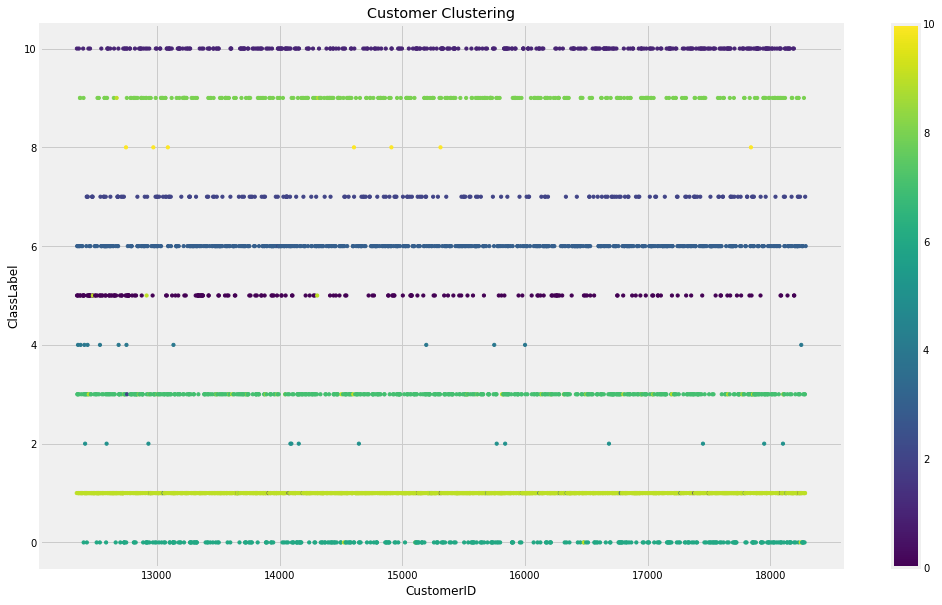

In [30]:
n_clusters = 11
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
cent = kmeans.cluster_centers_
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print('score de silhouette: {:<.3f}'.format(silhouette_avg))

In [27]:
pd.DataFrame(pd.Series(clusters_clients).value_counts(), columns = ['nb. de clients']).T

9    4    1    2    10   0    8    6   7   5   3 
nb. de clients  1843  564  554  345  314  304  194  181  13  12   7

In [31]:
class Class_Fit(object):
    def __init__(self, clf, params=None):
        if params:            
            self.clf = clf(**params)
        else:
            self.clf = clf()

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)
    
    def grid_search(self, parameters, Kfold):
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, Y):
        self.grid.fit(X, Y)
        
    def grid_predict(self, X, Y):
        self.predictions = self.grid.predict(X)
        print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y, self.predictions)))

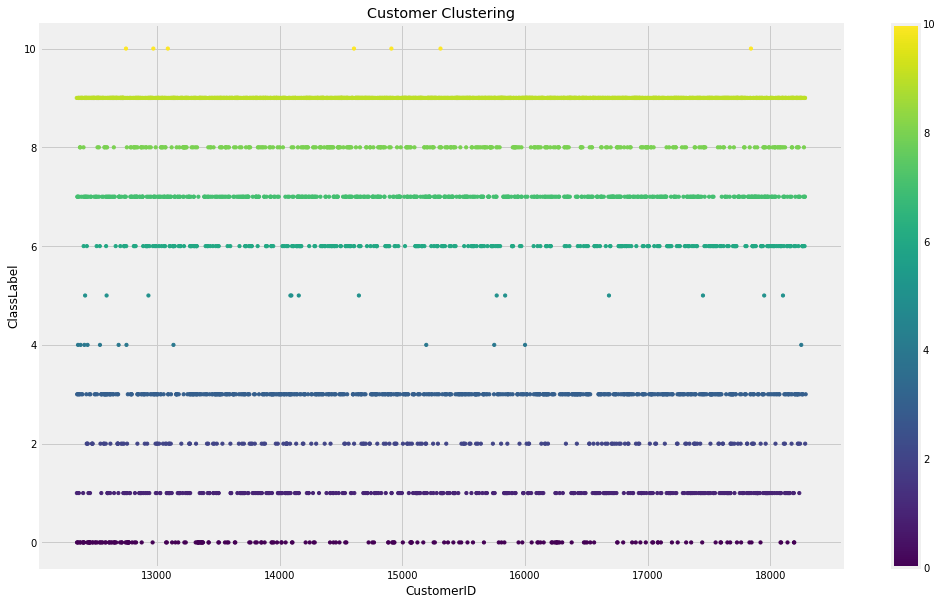

In [43]:
columns = ['mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4' ]
X = selected_customers[columns]
selected_customers.loc[:, 'cluster'] = clusters_clients
Y = selected_customers['cluster']

means = pd.DataFrame(clusters_clients)
#t.insert((t.shape[1]),'means',means)
#transactions_per_user.insert((transactions_per_user.shape[1]),'ClassLabel',means)
#Plot the clusters obtained using k means
fig = plt.figure(figsize=(16,10))
ax = fig.add_subplot(111)
scatter = ax.scatter(selected_customers['CustomerID'],selected_customers['cluster'],c=means[0],s=10)
ax.set_title('Customer Clustering')
ax.set_xlabel('CustomerID')
ax.set_ylabel('ClassLabel')
plt.colorbar(scatter)

In [33]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y, train_size = 0.8)

In [30]:
svc = Class_Fit(clf = svm.LinearSVC)
svc.grid_search(parameters = [{'C':np.logspace(-2,2,10)}], Kfold = 5)
svc.grid_fit(X = X_train, Y = Y_train)
svc.grid_predict(X_test, Y_test)

Precision: 89.04 % 


In [31]:
knn = Class_Fit(clf = neighbors.KNeighborsClassifier)
knn.grid_search(parameters = [{'n_neighbors': np.arange(1,50,1)}], Kfold = 5)
knn.grid_fit(X = X_train, Y = Y_train)
knn.grid_predict(X_test, Y_test)

Precision: 81.31 % 


In [32]:
tr = Class_Fit(clf = tree.DecisionTreeClassifier)
tr.grid_search(parameters = [{'criterion' : ['entropy', 'gini'], 'max_features' :['sqrt', 'log2']}], Kfold = 5)
tr.grid_fit(X = X_train, Y = Y_train)
tr.grid_predict(X_test, Y_test)

Precision: 83.85 % 


In [33]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score

logmodel = LogisticRegression()
logmodel.fit(X_train, Y_train)
 
predictions = logmodel.predict(X_test)
#print(classification_report(Y_test, predictions))
#print(confusion_matrix(Y_test, predictions))
print("Precision: {:.2f} % ".format(100*metrics.accuracy_score(Y_test,predictions)))

Precision: 86.74 % 


In [35]:
from sklearn.ensemble import RandomForestRegressor

score = []
for i in range(1,50):
    regressor = RandomForestRegressor(n_estimators=i,random_state=0)
    regressor.fit(X_train, Y_train)
    predictions = regressor.predict(X_test)
    score.append(np.sqrt(metrics.mean_squared_error(Y_test,predictions)))

#print('Mean Absolute Error:', metrics.mean_absolute_error(Y_test,predictions))
#print('Mean Squared Error:', metrics.mean_squared_error(Y_test,predictions))
#print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(Y_test,predictions)))

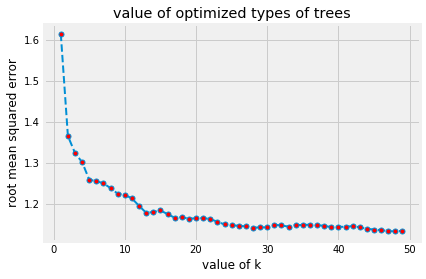

In [36]:
k = range(1,50)
plt.xlabel('value of k')
plt.ylabel('root mean squared error')
plt.title('value of optimized types of trees')
plt.plot(k,score,linewidth = 2,marker='o',markersize=5,markerfacecolor='red',linestyle='dashed')
plt.show()

# optimal value at 10

In [158]:
#selected_customers[selected_customers['cluster']==10]
selected_customers.head()

CustomerID  count      min      max         mean      sum    categ_0  \
0     12347.0      7   224.82  1294.32   615.714286  4310.00  12.041531   
1     12348.0      4   227.44   892.80   449.310000  1797.24  20.030714   
2     12349.0      1  1757.55  1757.55  1757.550000  1757.55  46.021450   
3     12350.0      1   334.40   334.40   334.400000   334.40  11.961722   
4     12352.0      7   144.35   840.30   340.815714  2385.71  64.322571   

     categ_1    categ_2    categ_3    categ_4  cluster  
0  20.805104  29.540371  11.237123  26.375870        9  
1   0.000000   0.000000  38.016069  41.953217        1  
2  12.245455  10.713778   4.513101  26.506216        0  
3  27.900718   0.000000  11.692584  48.444976        3  
4   4.071325  14.601523   1.299404  15.705178        7

In [56]:
data.head()

InvoiceNo StockCode                          Description  Quantity  \
0    536365    85123A   WHITE HANGING HEART T-LIGHT HOLDER         6   
1    536365     71053                  WHITE METAL LANTERN         6   
2    536365    84406B       CREAM CUPID HEARTS COAT HANGER         8   
3    536365    84029G  KNITTED UNION FLAG HOT WATER BOTTLE         6   
4    536365    84029E       RED WOOLLY HOTTIE WHITE HEART.         6   

        InvoiceDate  UnitPrice  CustomerID         Country  
0  01-12-2010 08:26       2.55     17850.0  United Kingdom  
1  01-12-2010 08:26       3.39     17850.0  United Kingdom  
2  01-12-2010 08:26       2.75     17850.0  United Kingdom  
3  01-12-2010 08:26       3.39     17850.0  United Kingdom  
4  01-12-2010 08:26       3.39     17850.0  United Kingdom

In [263]:
def recommend_on_customer_purchase_pattern(customerID):

    print("The items purchased by customer having customer ID : %s"%(customerID))
    print("-------------------------------------------------------------------------------------")
    print(data[data['CustomerID']==customerID][['Description','InvoiceNo','StockCode','Quantity']][:21])
    print("---------------------------------------------------------------------------------------")
    
    customerID_cluster = int(selected_customers[selected_customers['CustomerID']==customerID]['cluster'])
    customerID_cluster_table = selected_customers[selected_customers['cluster']==customerID_cluster]
    customerID_table=customerID_cluster_table[customerID_cluster_table.CustomerID==customerID]
    customerID_cluster_table=customerID_cluster_table[customerID_cluster_table.CustomerID!=customerID]
    customerID_table=customerID_table.reset_index(drop = True)
    customerID_cluster_table=customerID_cluster_table.reset_index(drop =True)
    #print(customerID_table)
    #print("---------------------------------------------------------------------------------------")
    #print(customerID_cluster_table)
    #print("---------------------------------------------------------------------------------------")
      
    #s = customerID_cluster_table.corr(method = 'pearson')
    #sns.heatmap(s)
    
    threshold = 21
    a = customerID_table['categ_0']
    similar_customer_list = customerID_cluster_table[(abs(customerID_cluster_table['categ_0'] - customerID_table['categ_0'][0])<=threshold) & (abs(customerID_cluster_table['categ_1'] - customerID_table['categ_1'][0])<=threshold) & (abs(customerID_cluster_table['categ_2'] - customerID_table['categ_2'][0])<=threshold) & (abs(customerID_cluster_table['categ_3'] - customerID_table['categ_3'][0])<=threshold) & (abs(customerID_cluster_table['categ_4'] - customerID_table['categ_4'][0])<=threshold)]  
    similar_customer_list = similar_customer_list.reset_index(drop = True)
    #print(similar_customer_list)
    similar_customer_list = similar_customer_list.sample(frac=1).reset_index(drop=True)
    #print(similar_customer_list)
    
    print("The items recommended for customer ID : %s "%(customerID))
    print("---------------------------------------------------------------------------------------")
    recommended_products = pd.merge(data[['Description','CustomerID']],similar_customer_list,left_on='CustomerID',right_on='CustomerID',how = 'inner')
    print(recommended_products['Description'][:21])
    print("---------------------------------------------------------------------------------------")


a = 17850.0
recommend_on_customer_purchase_pattern(a)

The items purchased by customer having customer ID : 17850.0
-------------------------------------------------------------------------------------
                            Description InvoiceNo StockCode  Quantity
0    WHITE HANGING HEART T-LIGHT HOLDER    536365    85123A         6
1                   WHITE METAL LANTERN    536365     71053         6
2        CREAM CUPID HEARTS COAT HANGER    536365    84406B         8
3   KNITTED UNION FLAG HOT WATER BOTTLE    536365    84029G         6
4        RED WOOLLY HOTTIE WHITE HEART.    536365    84029E         6
5          SET 7 BABUSHKA NESTING BOXES    536365     22752         2
6     GLASS STAR FROSTED T-LIGHT HOLDER    536365     21730         6
7                HAND WARMER UNION JACK    536366     22633         6
8             HAND WARMER RED POLKA DOT    536366     22632         6
47            HAND WARMER RED POLKA DOT    536372     22632         6
48               HAND WARMER UNION JACK    536372     22633         6
49   WHITE HA